In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wfdb
import csv
import os
from scipy.signal import butter, filtfilt
#from PyEMD import EMD
import emd
import time
import pywt
import biosppy.signals.ecg as bsp_ecg
import biosppy.signals.tools as bsp_tools

from utils import print_signal_qrs, print_signal, calcul_f1, perf

from scipy.interpolate import CubicSpline

In [2]:
def upsample_signal(original_signal, upsampled_length):
    # Coordonnées originales du signal
    original_indices = np.linspace(0, len(original_signal) - 1, num=len(original_signal))
    
    # Coordonnées désirées du signal upsampled
    upsampled_indices = np.linspace(0, len(original_signal) - 1, num=upsampled_length)
    
    # Interpolation spline cubique
    cs = CubicSpline(original_indices, original_signal)
    
    # Signal upsampled
    upsampled_signal = cs(upsampled_indices)
    
    return upsampled_signal

def wavelet_decomposition(sig, idx, nb_wave):
    # Décomposition en ondelettes
    coeffs = pywt.wavedec(sig, "haar", level=idx)
    
    # Prendre les coefficients aux niveaux idx-4 et idx-5
    w4 = coeffs[-2]
    w5 = coeffs[-1]
    
    # Upsample les coefficients à la longueur du signal original
    w4_upsampled = upsample_signal(w4, len(sig))
    w5_upsampled = upsample_signal(w5, len(sig))
    
    # Multiplication des coefficients upsampled et prise de la valeur absolue
    resultat = np.abs(w4_upsampled * w5_upsampled)
    
    return resultat

In [7]:
def highpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    high = cutoff / nyquist
    b, a = butter(order, high, btype='high')
    y = filtfilt(b, a, data)
    return y

def lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    low = cutoff / nyquist
    b, a = butter(order, low, btype='low')
    y = filtfilt(b, a, data)
    return y

def differentiate(data):
    return np.diff(data, prepend=data[0])

def squaring(data):
    return np.square(data)

def moving_window_integration(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def preprocess_ecg(data, fs, high, low):
    high_passed_data = highpass_filter(data, high, fs)
    low_passed_data = lowpass_filter(high_passed_data, low, fs)
    differentiated_data = differentiate(low_passed_data)
    squared_data = squaring(differentiated_data)
    integrated_data = moving_window_integration(squared_data, 20)
    return integrated_data

In [65]:
def print_signal(signal, start = 0, description= "A", unite = " "):
    plt.figure(figsize = (10, 3))
    plt.plot(range(start, start + len(signal)), signal)
    plt.title(label= description)
    plt.xlabel('frame du signal')
    if unite != " ":
        plt.ylabel(unite)
    plt.show()

In [31]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/207.csv')#[:20000] #207
mini = 0
maxi = len(df) #10000

ecg_signal = np.array(df["MLII"], dtype=np.float32)
fs = 360
QRS = df["labels"].dropna().tolist()

QRS = [int(R) for R in QRS if R <= maxi and R <= maxi]

In [32]:
prepro = 1 
h = None
w = 1
seuil = 0.0001 #2  #

if prepro == 1:
    h = wavelet_decomposition(ecg_signal, 6, 2)
    w = 5
else:
    preprocess_ecg(ecg_signal, fs, 5, 15) 
    
h_lisse = np.convolve(h, np.ones(w)/w, mode='same')
seuil = np.mean(h_lisse)

In [63]:
seuil

0.000978280283863735

In [40]:
mox = 30000
peaks = np.array([i for i in range(mox) if h_lisse[i] > seuil])

In [41]:
thr = 36*3
diff = peaks[1:]-peaks[:-1]
gps = np.concatenate([[0], np.cumsum(diff>=thr)])
temp = [peaks[gps==i] for i in range(gps[-1]+1)]

In [42]:
s = 0
taille_groupe = np.zeros(mox)
for groupos in temp:
    if len(groupos) >= int(0.12*fs):
        taille_groupe[groupos[0]:groupos[-1]] = len(groupos)

moy = []
window_moy = 1000
for i in range(0,len(taille_groupe), window_moy):
    moy.extend([np.mean(taille_groupe[i:i+window_moy])]*window_moy)

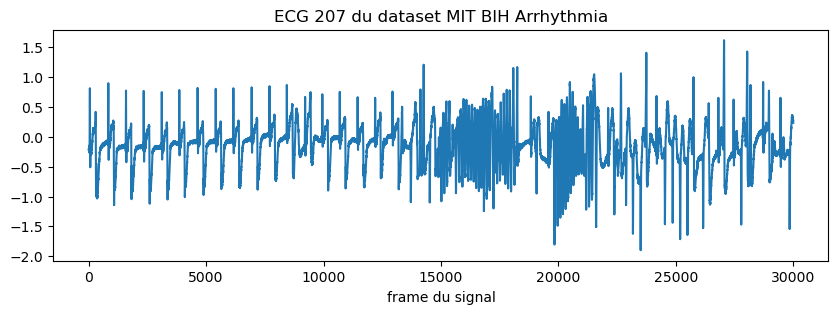

In [47]:
print_signal(ecg_signal[:mox], description = "ECG 207 du dataset MIT BIH Arrhythmia")

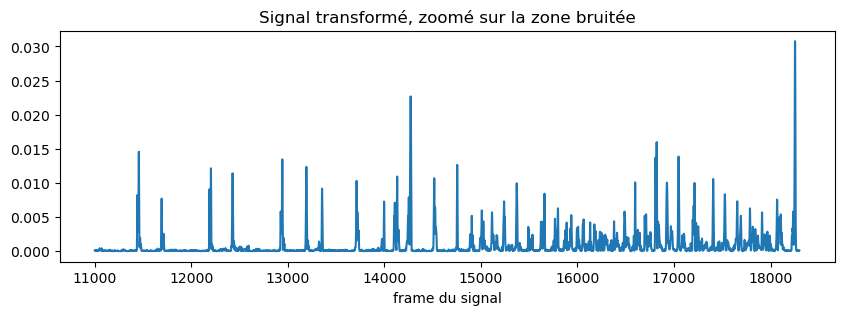

In [58]:
start = 11000
print_signal(h_lisse[start:18300], description="Signal transformé, zoomé sur la zone bruitée", start = start)

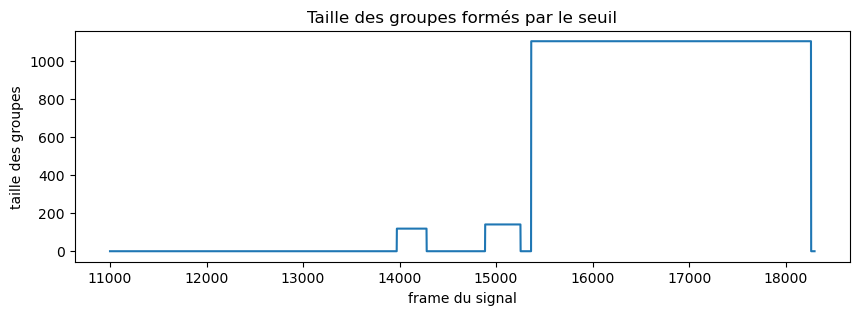

In [69]:
start = 11000
print_signal(taille_groupe[start:18300], description="Taille des groupes formés par le seuil", start = start, unite = "taille des groupes")

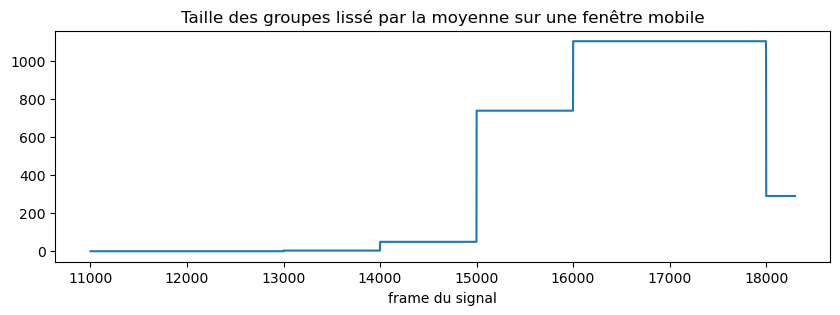

In [67]:
print_signal(moy[start:18300], description="Taille des groupes lissé par la moyenne sur une fenêtre mobile", start = start)

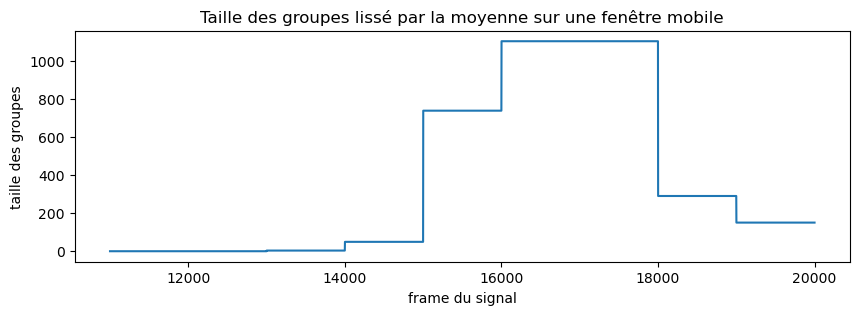

In [66]:
print_signal(moy[start:20000], description="Taille des groupes lissé par la moyenne sur une fenêtre mobile", start = start, unite="taille des groupes")